In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from datetime import time


# CLASES

In [2]:
#variables locales

rango_horas = [7,18]
num_productos = 3
rango_cantidad = [50, 601, 50]


## PEDIDO

In [3]:
class Pedido:
    def __init__(self, id, producto, cantidad, hora_pedido):
        self.id = id
        self.producto = producto
        self.cantidad = cantidad
        self.hora_pedido = hora_pedido

    def __str__(self):
        return f"Pedido {self.id}: {self.producto} ({self.cantidad} unidades) a las {self.hora_pedido} horas."
        

In [4]:
class Trabajo:
    def __init__(self, id, cantidad_elementos):
        self.id = id #int
        self.cantidad_elementos = cantidad_elementos #int

In [5]:
print(Pedido(1,2,3,4))

Pedido 1: 2 (3 unidades) a las 4 horas.


In [7]:
class GestorPedidos:
    #lista de objetos Pedido
    def __init__(self, pedidos):
        self.pedidos_originales = pedidos 
        self.pedidos = pedidos
        self.next_id = max(pedido.id for pedido in pedidos) + 1 #Id para el siguiente pedido

    def agregar_pedidos(self, lam=2):

        # Agregar ´pedidos a la lista con una distribición de poisson

        n_nuevos = np.random.poisson(lam) #Numero de pedidos nuevos
        nuevos_pedidos = [] #lista con nuevos pedidos (contiene objetos de la clase Pedido)

        for _ in range(n_nuevos):
            producto = random.randint(1,num_productos)
            cantidad = random.randrange(*rango_cantidad)
            hora = time(np.random.randint(*rango_horas))
            nuevo_pedido = Pedido(self.next_id, producto, cantidad, hora)
            self.pedidos.append(nuevo_pedido)
            nuevos_pedidos.append(nuevo_pedido)
            self.next_id += 1
        
        return nuevos_pedidos

    def eliminar_pedidos(self, prob = 0.1):

        #eliminar pedidos con una pribabiulidad uniforme de 0.1

        num_pedidos_iniciales = len(self.pedidos)

        id_pedidos_eliminados = [] #lista con los ids de los pedidos eliminados

        pedidos_nuevos = [] # reinicio lista de pedidos

        for pedido in self.pedidos:
            if random.uniform(0,1) > prob: pedidos_nuevos.append(pedido)
            else: id_pedidos_eliminados.append(pedido.id)       

        self.pedidos =  pedidos_nuevos
        
        num_pedidos_eliminados = num_pedidos_iniciales - len(self.pedidos)

        return id_pedidos_eliminados
        
    def simular_cambio(self, lam=2, prob=0.1):

        #simular una iteración en la que la lista de pedidos puede ser modificada al agregar o quitar pediodos con su respectiva dist. probabilidad

        eliminados = self.eliminar_pedidos(prob=prob)
        agregados = self.agregar_pedidos(lam=lam)
        

        return {"agregados": agregados, "eliminados": eliminados}


    def mostrar_pedidos(self):
        """
        Muestra la lista actual de pedidos.
        """
        for pedido in self.pedidos:
            print(pedido)


    def to_dataframe(self):
        """
        Exporta la lista actual de pedidos a un DataFrame de pandas.
        """
        data = [{
            "id_pedido": pedido.id,
            "producto": pedido.producto,
            "cantidad": pedido.cantidad,
            "hora_pedido": pedido.hora_pedido
        } for pedido in self.pedidos]
        return pd.DataFrame(data)



In [105]:
class Montecarlo():
    def __init__(self, pedidos_iniciales, lam, prob, iteraciones):
        self.pedidos_iniciales = pedidos_iniciales
        self.lam = lam
        self.prob = prob
        self.iteraciones = iteraciones
        self.data = {}
        
        
    def Ejecutar(self):
        #iteraciones

        gestor_pedidos = GestorPedidos(self.pedidos_iniciales)

        self.data = {}
        self.altas = []
        self.bajas = []
        self.total = []

        for i in range(self.iteraciones):
            gestor_pedidos = GestorPedidos(self.pedidos_iniciales)

            modificaciones = gestor_pedidos.simular_cambio(self.lam, self.prob)
            num_altas = len(modificaciones['agregados'])
            num_bajas = len(modificaciones['eliminados'])
                            
            self.data[i] = {'Altas':num_altas, 'Bajas':num_bajas, 'Total': num_altas-num_bajas }

        self.altas = [v['Altas'] for v in self.data.values()]
        self.bajas = [v['Bajas'] for v in self.data.values()]
        self.totales= [v['Total'] for v in self.data.values()]
            
        
        print(f'{self.iteraciones} iteraciones completadas')
        
        self.MostrarDistribuciones()
        self.Estadisticas()
    
    def MostrarDistribuciones(self):
        max_totales = max([abs(i) for i in self.totales])

        # Crear histogramas
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.hist(self.altas, bins=max(self.altas), color='skyblue', alpha=0.7, edgecolor='black')
        plt.title('Distribución de Altas')
        plt.xlabel('Cantidad de Altas')
        plt.ylabel('Frecuencia')

        plt.subplot(1, 3, 2)
        plt.hist(self.bajas, bins=max(self.bajas), color='salmon', alpha=0.7, edgecolor='black')
        plt.title('Distribución de Bajas')
        plt.xlabel('Cantidad de Bajas')

        plt.subplot(1, 3, 3)
        plt.hist(self.totales, bins=max_totales*2, color='lightgreen', alpha=0.7, edgecolor='black')
        plt.title('Distribución del Total')
        plt.xlabel('Valor Total')

        plt.tight_layout()
        plt.show()
    
    def Estadisticas(self):
        media_altas = np.mean(self.altas)
        media_bajas = np.mean(self.bajas)
        media_total = np.mean(self.totales)

        info = {'Media Altas': media_altas,
                'Media Bajas': media_bajas,
                'Media Total': media_total}
        
        print(info)

        return info

# IMPLEMENTACIÓN

In [106]:
# DataFrame con pedidos iniciales
df_pedidos = pd.read_csv('pedidos.csv')
df_pedidos = df_pedidos.set_index('id_pedido')
df_pedidos['Hora pedido'] = pd.to_datetime(df_pedidos['Hora pedido'], format='%H:%M').dt.time

df_pedidos

,Producto,Cantidad,Hora pedido
id_pedido,,,
1,1,300,07:00:00
2,1,400,09:00:00
3,3,600,07:00:00
4,2,400,07:00:00
5,1,600,13:00:00
6,1,300,14:00:00
7,2,400,11:00:00
8,3,200,09:00:00


In [107]:
# Convertir el DataFrame en una lista de objetos Pedido
pedidos_iniciales = [
    Pedido(row.name, row['Producto'], row['Cantidad'], row['Hora pedido'])
    for i, row in df_pedidos.iterrows()
]

lam = 3
prob_baja = 0.2
iteraciones = 1000

1000 iteraciones completadas


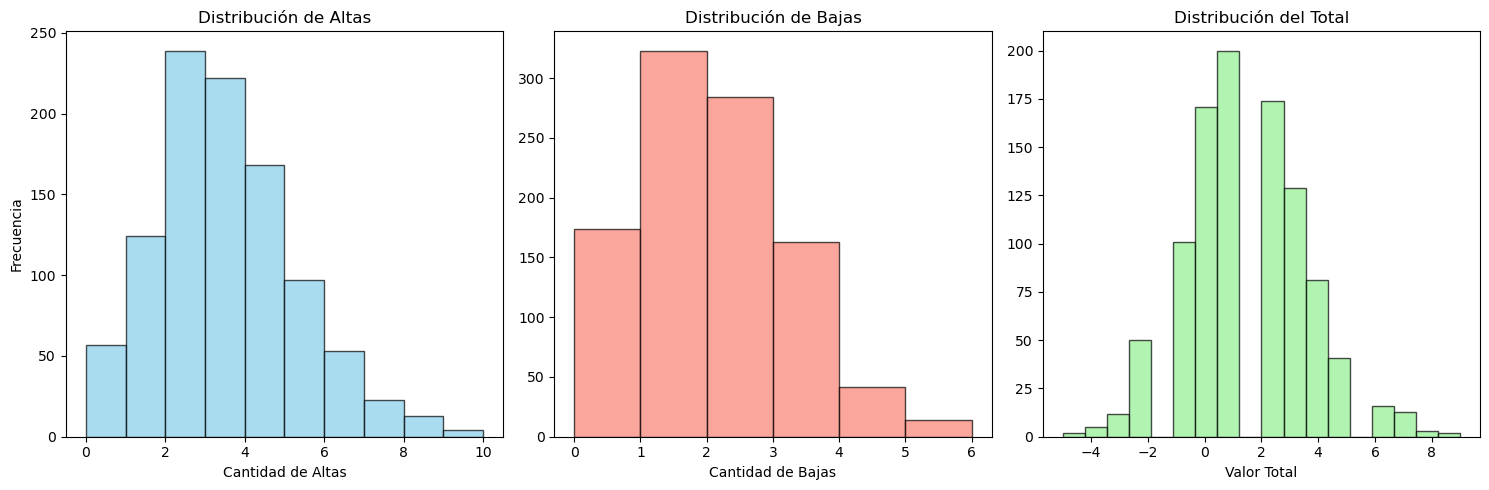

{'Media Altas': 3.045, 'Media Bajas': 1.619, 'Media Total': 1.426}


In [108]:
simualacion = Montecarlo(pedidos_iniciales, lam, prob_baja, iteraciones) #creo objeto montecarlo
simualacion.Ejecutar()